In [1]:
import math

def mars_radius(latitude):
    """
    Calculate the radius of Mars at a given latitude, assuming Mars is an oblate ellipsoid.

    Parameters:
    latitude (float): Latitude in degrees.

    Returns:
    float: Radius of Mars at the specified latitude in kilometers.
    """
    # Equatorial and polar radii of Mars in kilometers
    equatorial_radius = 3396.19  # Semi-major axis (a)
    polar_radius = 3376.2       # Semi-minor axis (b)

    # Convert latitude from degrees to radians
    lat_rad = math.radians(latitude)

    # Formula for the radius of an oblate ellipsoid at a given latitude
    numerator = (equatorial_radius**2 * math.cos(lat_rad))**2 + (polar_radius**2 * math.sin(lat_rad))**2
    denominator = (equatorial_radius * math.cos(lat_rad))**2 + (polar_radius * math.sin(lat_rad))**2
    radius = math.sqrt(numerator / denominator)

    return radius

# Example usage:
latitude = -42.4  # Latitude in degrees
print(f"Radius of Mars at latitude {latitude}°: {mars_radius(latitude):.2f} km")


Radius of Mars at latitude -42.4°: 3387.17 km


/Users/phillipsm/anaconda3/envs/hypy_scat/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


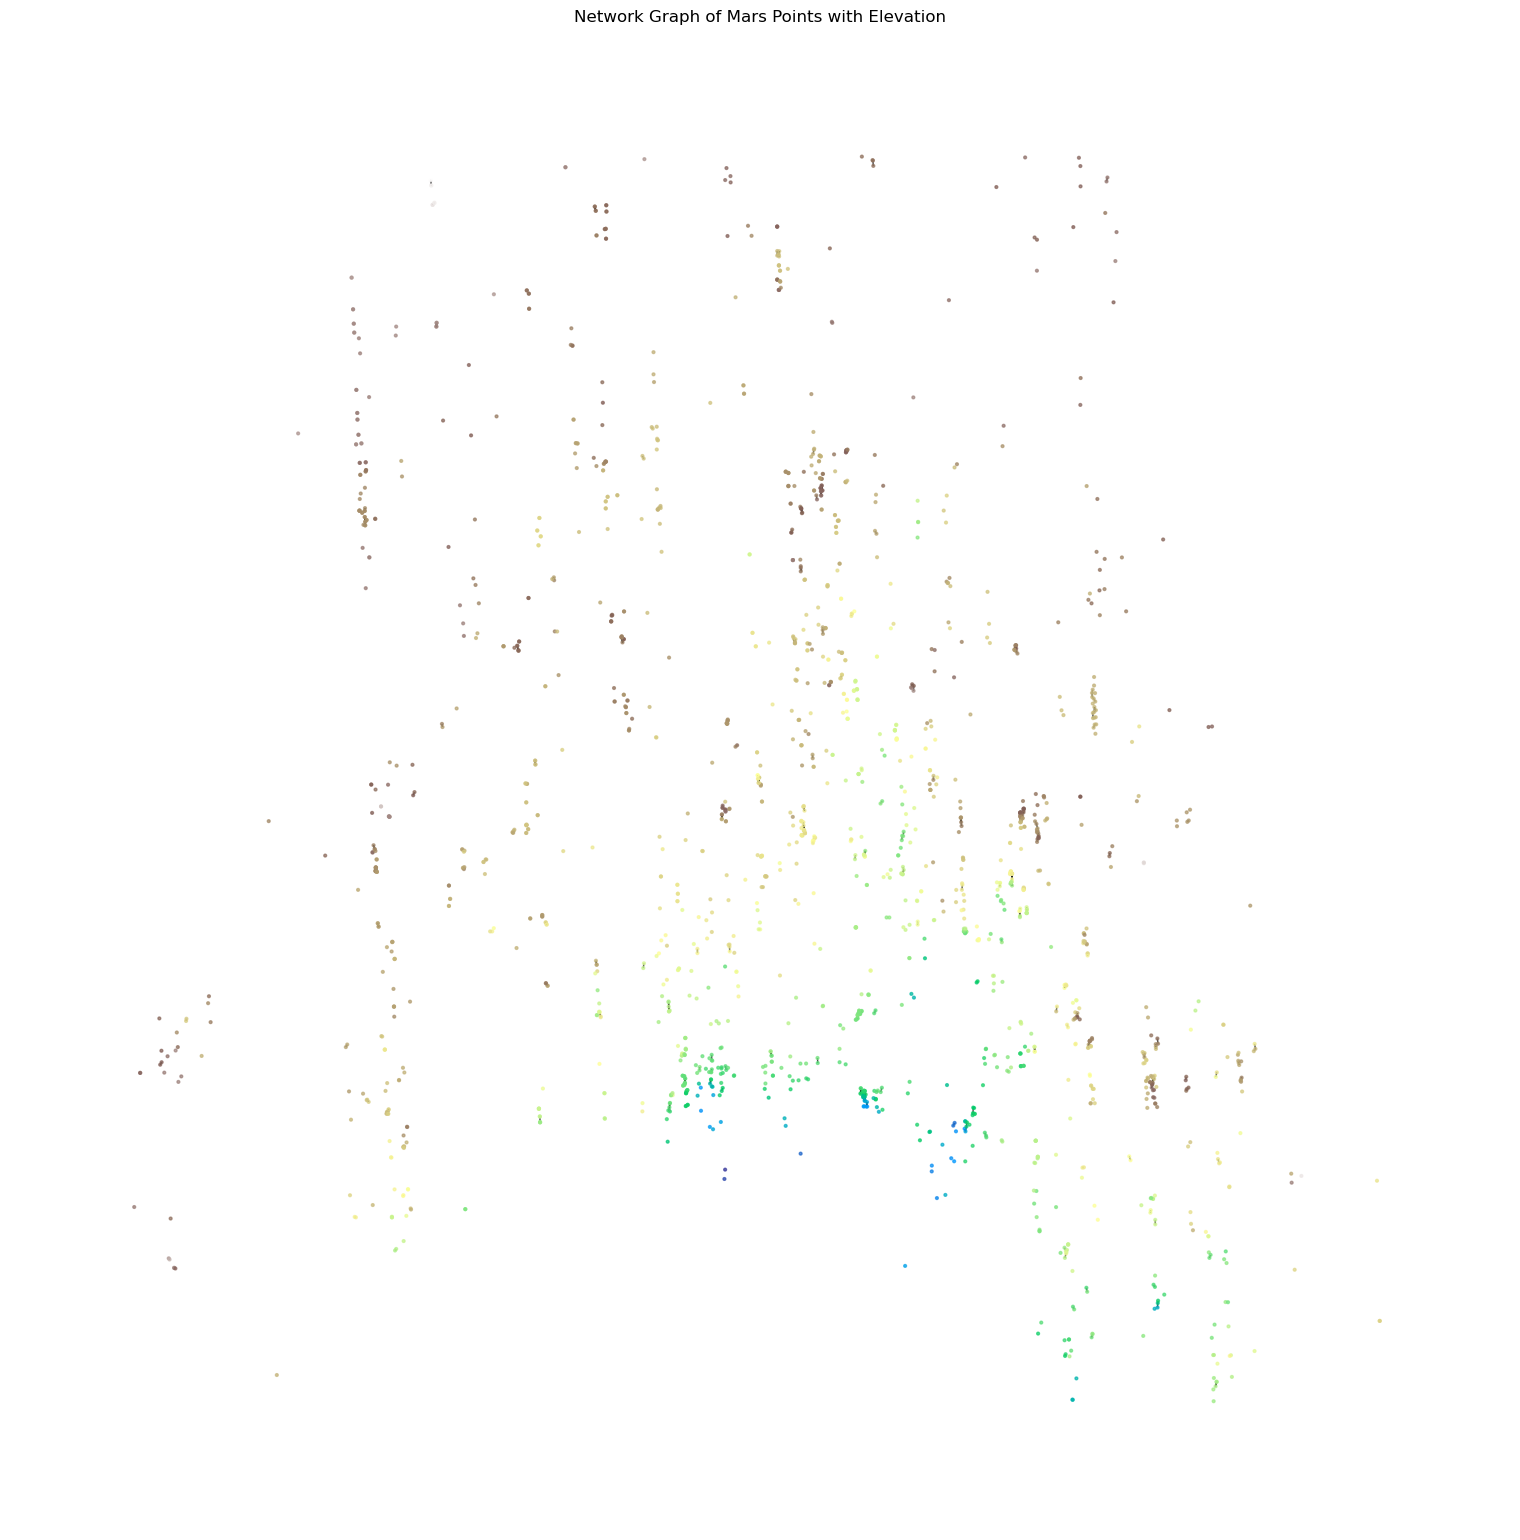

In [ ]:
import geopandas as gpd
import numpy as np
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy.spatial import distance
import math
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Radius of Mars in kilometers at Argyre (assuming ellipsoid with 3396.19, 3376.2)
hellas_center_point = (-42.4, 70.5)
R_MARS = mars_radius(hellas_center_point[0])

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points on Mars (in kilometers)
    given their latitudes and longitudes.
    
    :param lat1: Latitude of the first point in degrees
    :param lon1: Longitude of the first point in degrees
    :param lat2: Latitude of the second point in degrees
    :param lon2: Longitude of the second point in degrees
    :return: Distance between the two points in kilometers
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    d = R_MARS * c
    return d

os.environ['PROJ_IGNORE_CELESTIAL_BODY'] = 'YES'

def custom_distance(p1, p2):
    lon1, lat1 = p1
    lon2, lat2 = p2
    return round(haversine(lon1, lat1, lon2, lat2), 2)

# Load your GeoPackage file
file_path = f"/Users/phillipsm/Documents/Research/MassifMapping/Argyre_QGIS/shape_files/Hellas/hellas_mineral_units_points.gpkg"
gdf = gpd.read_file(file_path)

gdf['Distance_to_center_km'] = gdf.apply(lambda row: haversine(float(row['Latitude'].strip()), float(row['Longitude'].strip()), hellas_center_point[0], hellas_center_point[1]), axis=1)

# Define the categories to keep
# categories_of_interest = ['Plagioclase', 'Olivine (Fe/Mg)', 'LCP', 'HCP']
categories_of_interest = ['Plagioclase', 'Type 1 Olivine', 'Type 2 Olivine', 'Olivine + HCP', 'LCP', 'HCP']    

recat_dict = {'Plagioclase':'Plagioclase', 'Plagioclase Fe_smectite':'Plagioclase', 'Plagioclase Mg_smectite':'Plagioclase',
            'Mg_Olivine':'Type 1 Olivine', 'Mg_Olivine Fe_Olivine':'Type 1 Olivine', 'Mg_Olivine Fe_smectite':'Type 1 Olivine', 'Mg_Olivine HCP':'Olivine + HCP', 'Mg_Olivine LCP':'Type 1 Olivine', 'Mg_Olivine Mg_smectite':'Type 1 Olivine',
            'Fe_Olivine':'Type 2 Olivine', 'Fe_Olivine HCP':'Olivine + HCP', 'Fe_Olivine Plagioclase':'Type 2 Olivine', 'Fe_Olivine Mg_smectite':'Type 2 Olivine',
            'LCP':'LCP', 'LCP HCP':'LCP'}

# Re-categorize the 'Category' column using the recat_dict
gdf['Category'] = gdf['Category'].map(recat_dict).fillna(gdf['Category'])

# geounits_of_interest = ['Argyre basin member 2', 'Argyre basin member 3', 'Argyre rim materials', 'Argyre rim and basin materials', 'Argye rim and basin materials', 'Argyre basin and rim materials','Young crater materials', 'Old crater materials']

# Strip leading and trailing spaces from the 'Category' column
gdf['Category'] = gdf['Category'].str.strip()

# Filter the GeoDataFrame to include only the categories of interest
gdf_filtered = gdf[gdf['Category'].isin(categories_of_interest)]

# make sure all the numerical columns are floats not str
# Ensure all numerical columns are floats
gdf_filtered['Longitude'] = gdf_filtered['Longitude'].astype(float)
gdf_filtered['Latitude'] = gdf_filtered['Latitude'].astype(float)
gdf_filtered['Elevation_m'] = gdf_filtered['Elevation_m'].astype(float)

# Convert the Elevation_km column to meters
# gdf_filtered['Elevation_m'] = gdf_filtered['Elevation']

# Reset the index after filtering
gdf_filtered = gdf_filtered.reset_index(drop=True)

# count the number of each category in the graph
category_counts = gdf_filtered['Category'].value_counts()
total_counts = category_counts.sum()
percent_category_dict = {}
for category, count in category_counts.items():
    percent_category_dict[category] = count/total_counts
    
# Convert coordinates from degrees to meters (if needed) using an appropriate projection
iau49900 = 'GEOGCS["Mars (2015) - Sphere / Ocentric",DATUM["Mars (2015) - Sphere",SPHEROID["Mars (2015) - Sphere",3396190,0,AUTHORITY["IAU","49900"]],AUTHORITY["IAU","49900"]],PRIMEM["Reference Meridian",0,AUTHORITY["IAU","49900"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["IAU","49900"]]'

gdf_filtered = gdf_filtered.to_crs(iau49900)  # Set to Mars-specific CRS

# Reset the index after filtering
gdf_filtered = gdf_filtered.reset_index(drop=True)

# Extract coordinates (X, Y) and convert them into a numpy array
coords = np.array([point.coords[0] for point in gdf_filtered.geometry])

# Create a spatial index to efficiently find the nearest neighbors
tree = spatial.cKDTree(coords)

# Set a threshold distance (e.g., 10 km) to connect nearby points
threshold_distance = 4 # in kilometers

# convert threshold distance to degrees
threshold_distance_deg = (threshold_distance / R_MARS) * (180 / math.pi)

dist_matrix = distance.cdist(coords, coords, metric=custom_distance)

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph, incorporate elevation in the position
for idx, row in gdf_filtered.iterrows():
    G.add_node(idx, label=row['Category'], position=(coords[idx][0], coords[idx][1], row['Elevation_m']))

# Add edges based on proximity (i.e., distance threshold)
for i, point1 in enumerate(coords):
    # Query for all points within the threshold distance
    nearby_points = tree.query_ball_point(point1, threshold_distance_deg)
    for j in nearby_points:
        if i != j:
            G.add_edge(i, j, weight=custom_distance(coords[i], coords[j]))
            G.add_edge(j, i, weight=custom_distance(coords[i], coords[j]))

# Draw the network graph with the elevation influencing node size or color
node_sizes = [float(G.nodes[node]['position'][2]) / 50 for node in G.nodes]  # Scale node size by elevation
node_colors = [float(G.nodes[node]['position'][2]) for node in G.nodes]  # Use elevation for color

# Create a colormap and normalize elevation values
norm = mcolors.Normalize(vmin=min(node_colors), vmax=max(node_colors))
cmap = cm.terrain

# Create a ScalarMappable object for color mapping
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This is needed to avoid warning messages

# Plot the network graph
plt.figure(figsize=(15, 15))

# Get positions for plotting, include elevation in z-axis (3D plot)
pos = {node: (G.nodes[node]['position'][0], G.nodes[node]['position'][1]) for node in G.nodes}

# Draw the network graph with the elevation influencing node size or color
# node_sizes = [G.nodes[node]['position'][2] / 100 for node in G.nodes]  # Scale node size by elevation
# node_colors = [G.nodes[node]['position'][2] for node in G.nodes]  # Use elevation for color

# Draw the network graph
nx.draw(G, pos, with_labels=False, node_size = 4, node_color=node_colors, cmap=plt.cm.terrain, font_size=8, font_weight='bold', alpha=0.7)

# Add a color bar using the ScalarMappable object
# plt.colorbar(sm, label='Elevation (m)')

plt.title("Network Graph of Mars Points with Elevation")
plt.show()

# point file derived from polygons

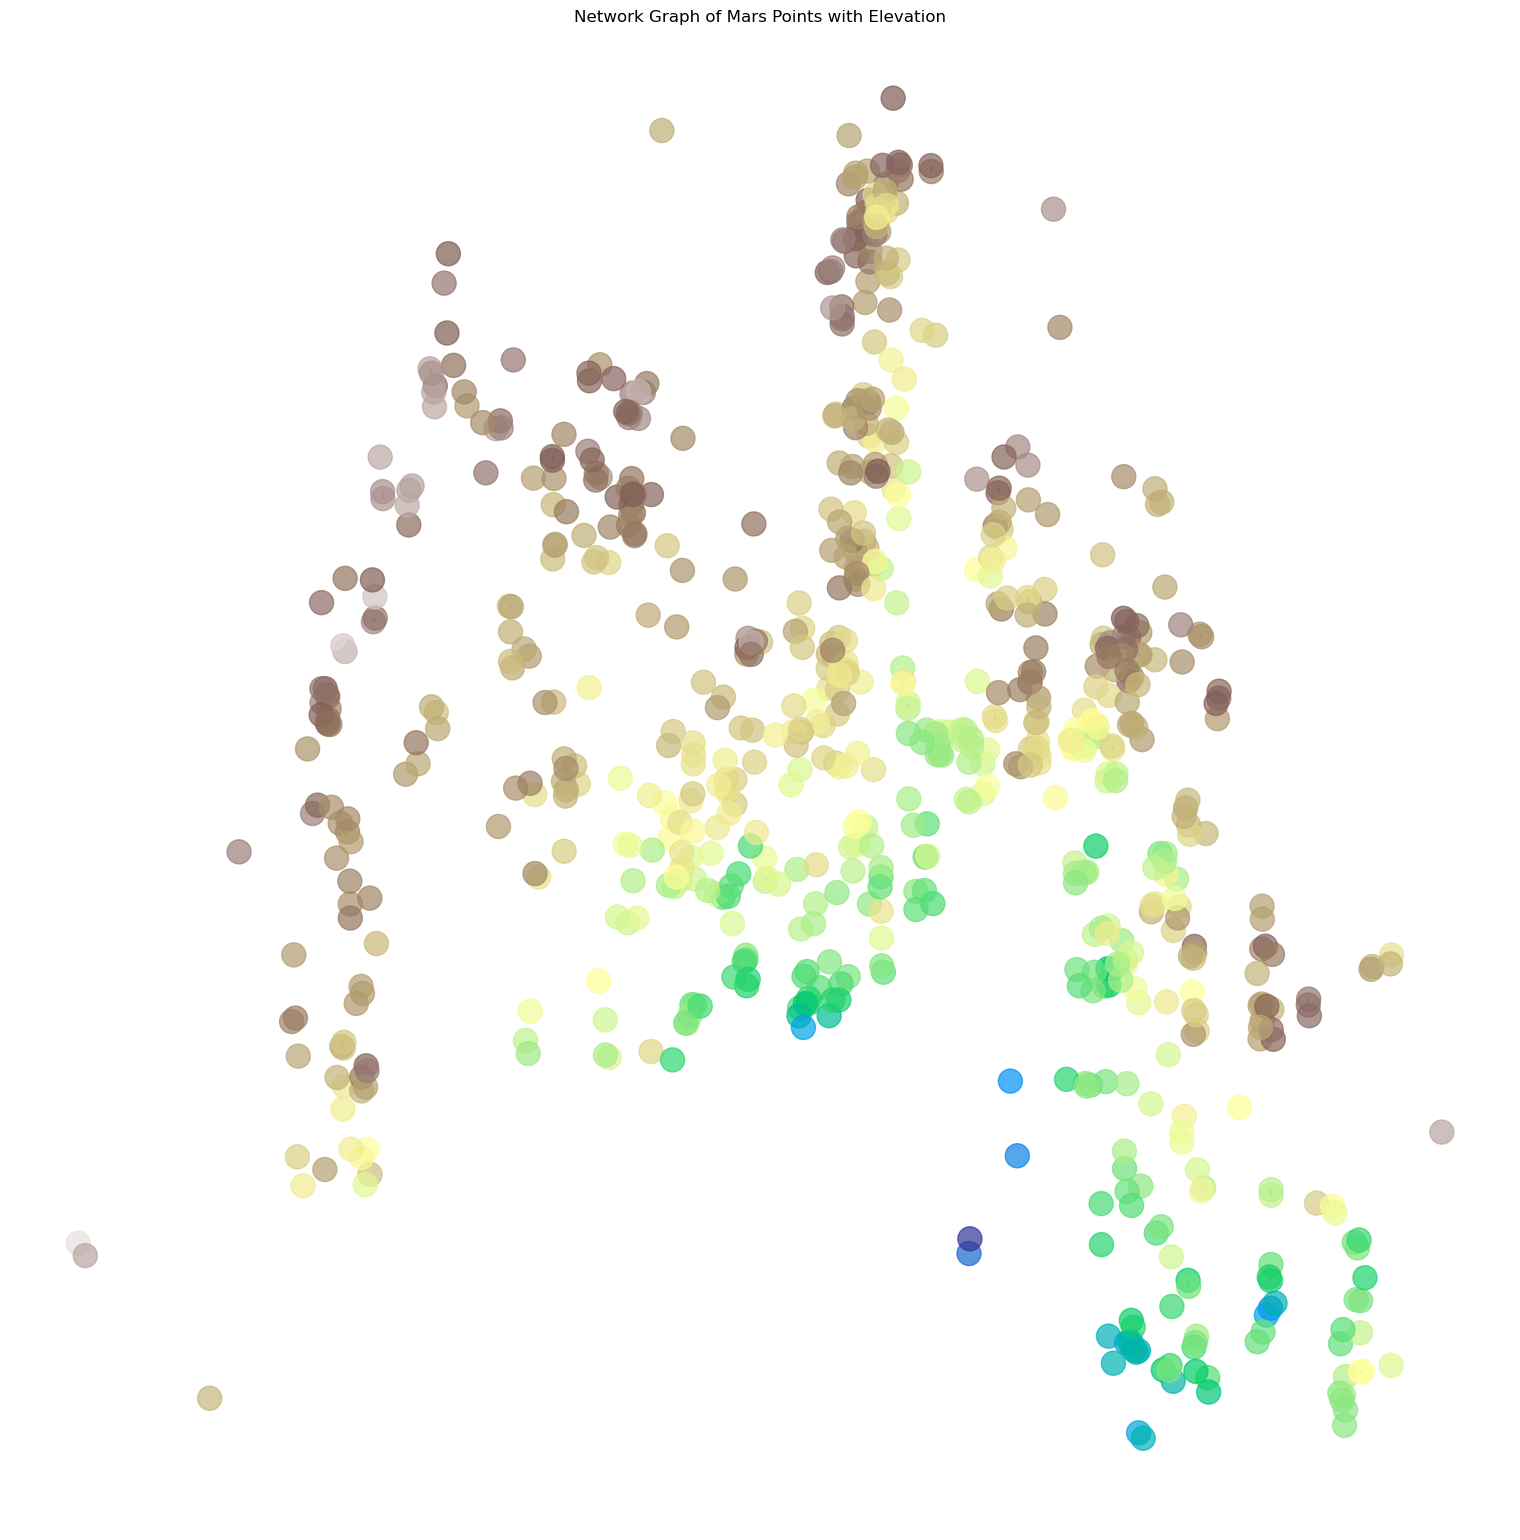

In [28]:
import geopandas as gpd
import numpy as np
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy.spatial import distance
import math

# Radius of Mars in kilometers at Argyre (assuming ellipsoid with 3396.19, 3376.2)
hellas_center_point = (-42.4, 70.5)
R_MARS = mars_radius(hellas_center_point[0])

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points on Mars (in kilometers)
    given their latitudes and longitudes.
    
    :param lat1: Latitude of the first point in degrees
    :param lon1: Longitude of the first point in degrees
    :param lat2: Latitude of the second point in degrees
    :param lon2: Longitude of the second point in degrees
    :return: Distance between the two points in kilometers
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    d = R_MARS * c
    return d

os.environ['PROJ_IGNORE_CELESTIAL_BODY'] = 'YES'

def custom_distance(p1, p2):
    lon1, lat1 = p1
    lon2, lat2 = p2
    return round(haversine(lon1, lat1, lon2, lat2), 2)

# Load your GeoPackage file
DATE_STRING = '12042024'
file_path = f"/Users/phillipsm/Documents/Research/MassifMapping/Argyre_QGIS/shape_files/Hellas/2022_paper/hellas_all_units_points_argyrePRJ_{DATE_STRING}.gpkg"
gdf = gpd.read_file(file_path)

# Define the categories to keep
categories_of_interest = ['olivine', 'olivine+hcp', 'olivine+lcp', 'olivine+plagioclase', 'plagioclase', 'lcp', 'hcp', 'lcp+hcp']
# geounits_of_interest = ['Nc', 'Nh', 'Nm', 'Npl1', 'Npl2', 'Npld', 'Nplh']
geounits_of_interest = ['Nh', 'Nm']

# Strip leading and trailing spaces from the 'Category' column
gdf['Category'] = gdf['Category'].str.strip()

# Filter the GeoDataFrame to include only the categories of interest
gdf_filtered = gdf[gdf['Category'].isin(categories_of_interest)]
gdf_filtered = gdf_filtered[gdf_filtered['GeoUnits'].isin(geounits_of_interest)]

# Convert the Elevation_km column to meters
gdf_filtered['Elevation_m'] = gdf_filtered['Elevation_km'] * 1000

# Reset the index after filtering
gdf_filtered = gdf_filtered.reset_index(drop=True)

# count the number of each category in the graph
category_counts = gdf_filtered['Category'].value_counts()
total_counts = category_counts.sum()
percent_category_dict = {}
for category, count in category_counts.items():
    percent_category_dict[category] = count/total_counts
    
# Convert coordinates from degrees to meters (if needed) using an appropriate projection
iau49900 = 'GEOGCS["Mars (2015) - Sphere / Ocentric",DATUM["Mars (2015) - Sphere",SPHEROID["Mars (2015) - Sphere",3396190,0,AUTHORITY["IAU","49900"]],AUTHORITY["IAU","49900"]],PRIMEM["Reference Meridian",0,AUTHORITY["IAU","49900"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["IAU","49900"]]'

gdf_filtered = gdf_filtered.to_crs(iau49900)  # Set to Mars-specific CRS

# Extract coordinates (X, Y) and convert them into a numpy array
coords = np.array([point.coords[0] for point in gdf_filtered.geometry])

# Create a spatial index to efficiently find the nearest neighbors
tree = spatial.cKDTree(coords)

# Set a threshold distance (e.g., 10 km) to connect nearby points
threshold_distance = 4 # in kilometers

# convert threshold distance to degrees
threshold_distance_deg = (threshold_distance / R_MARS) * (180 / math.pi)

dist_matrix = distance.cdist(coords, coords, metric=custom_distance)

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph, incorporate elevation in the position
for idx, row in gdf_filtered.iterrows():
    G.add_node(idx, label=row['Category'], position=(coords[idx][0], coords[idx][1], row['Elevation_m']))

# Add edges based on proximity (i.e., distance threshold)
for i, point1 in enumerate(coords):
    # Query for all points within the threshold distance
    nearby_points = tree.query_ball_point(point1, threshold_distance_deg)
    for j in nearby_points:
        if i != j:
            dt = custom_distance(coords[i], coords[j])
            if dt != 0:
                G.add_edge(i, j, weight=custom_distance(coords[i], coords[j]))
                G.add_edge(j, i, weight=custom_distance(coords[i], coords[j]))

import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Draw the network graph with the elevation influencing node size or color
node_sizes = [G.nodes[node]['position'][2] / 50 for node in G.nodes]  # Scale node size by elevation
node_colors = [G.nodes[node]['position'][2] for node in G.nodes]  # Use elevation for color

# Create a colormap and normalize elevation values
norm = mcolors.Normalize(vmin=min(node_colors), vmax=max(node_colors))
cmap = cm.terrain

# Create a ScalarMappable object for color mapping
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This is needed to avoid warning messages

# Plot the network graph
plt.figure(figsize=(15, 15))

# Get positions for plotting, include elevation in z-axis (3D plot)
pos = {node: (G.nodes[node]['position'][0], G.nodes[node]['position'][1]) for node in G.nodes}

# Draw the network graph with the elevation influencing node size or color
# node_sizes = [G.nodes[node]['position'][2] / 100 for node in G.nodes]  # Scale node size by elevation
# node_colors = [G.nodes[node]['position'][2] for node in G.nodes]  # Use elevation for color

# Draw the network graph
nx.draw(G, pos, with_labels=False, node_color=node_colors, cmap=plt.cm.terrain, font_size=8, font_weight='bold', alpha=0.7)

plt.title("Network Graph of Mars Points with Elevation")
plt.show()



In [29]:
import numpy as np
import pandas as pd

# Create a list to store the relative elevation differences with categories
elevation_diff_data = []

# Iterate through all edges in the graph
for node1, node2 in G.edges():
    # Get the elevation values for the two nodes
    elevation_node1 = G.nodes[node1]['position'][2]  # z-coordinate is the elevation (in meters)
    elevation_node2 = G.nodes[node2]['position'][2]
    
    # Get the categories of the nodes
    category_node1 = gdf_filtered.loc[node1, 'Category']
    category_node2 = gdf_filtered.loc[node2, 'Category']

    # Calculate the distance between the two nodes (already in kilometers)
    distance_km = G[node1][node2]['weight']

    # Check if the nodes are within the threshold distance (10 km)
    if distance_km <= 10:
        # Calculate the relative elevation difference
        elevation_diff = elevation_node1 - elevation_node2

        # Store the data including categories
        elevation_diff_data.append({'node1': node1, 'node2': node2, 'distance_km': distance_km, 
                                    'category_node1': category_node1, 'category_node2': category_node2,
                                    'elevation_node1': elevation_node1, 'elevation_node2': elevation_node2,
                                    'elevation_diff': elevation_diff})

# Convert the data into a DataFrame for easier analysis
elevation_diff_df = pd.DataFrame(elevation_diff_data)

# Display basic statistics about the relative elevation differences
elevation_diff_stats = elevation_diff_df.describe()

# Display the DataFrame with the elevation differences and statistics
elevation_diff_df.head(), elevation_diff_stats

# # optionally save
# elevation_diff_df.to_excel('elevation_diff_data.xlsx')

(   node1  node2  distance_km category_node1 category_node2  elevation_node1  \
 0      1    480         2.83    olivine+hcp    olivine+hcp     -2993.512315   
 1      1    329         1.00    olivine+hcp        olivine     -2993.512315   
 2      4    332         1.42            hcp        olivine        81.920245   
 3      9    287         2.33            hcp        olivine     -1095.271845   
 4     22    493         2.38            lcp        olivine     -1308.981481   
 
    elevation_node2  elevation_diff  
 0     -3186.226837      192.714522  
 1     -2616.692308     -376.820008  
 2       936.835616     -854.915371  
 3      -967.981432     -127.290412  
 4     -1291.241379      -17.740102  ,
             node1       node2  distance_km  elevation_node1  elevation_node2  \
 count  119.000000  119.000000   119.000000       119.000000       118.000000   
 mean   275.008403  516.630252     1.958655     -1104.340595     -1081.423968   
 std    173.912285  158.980058     0.922768   

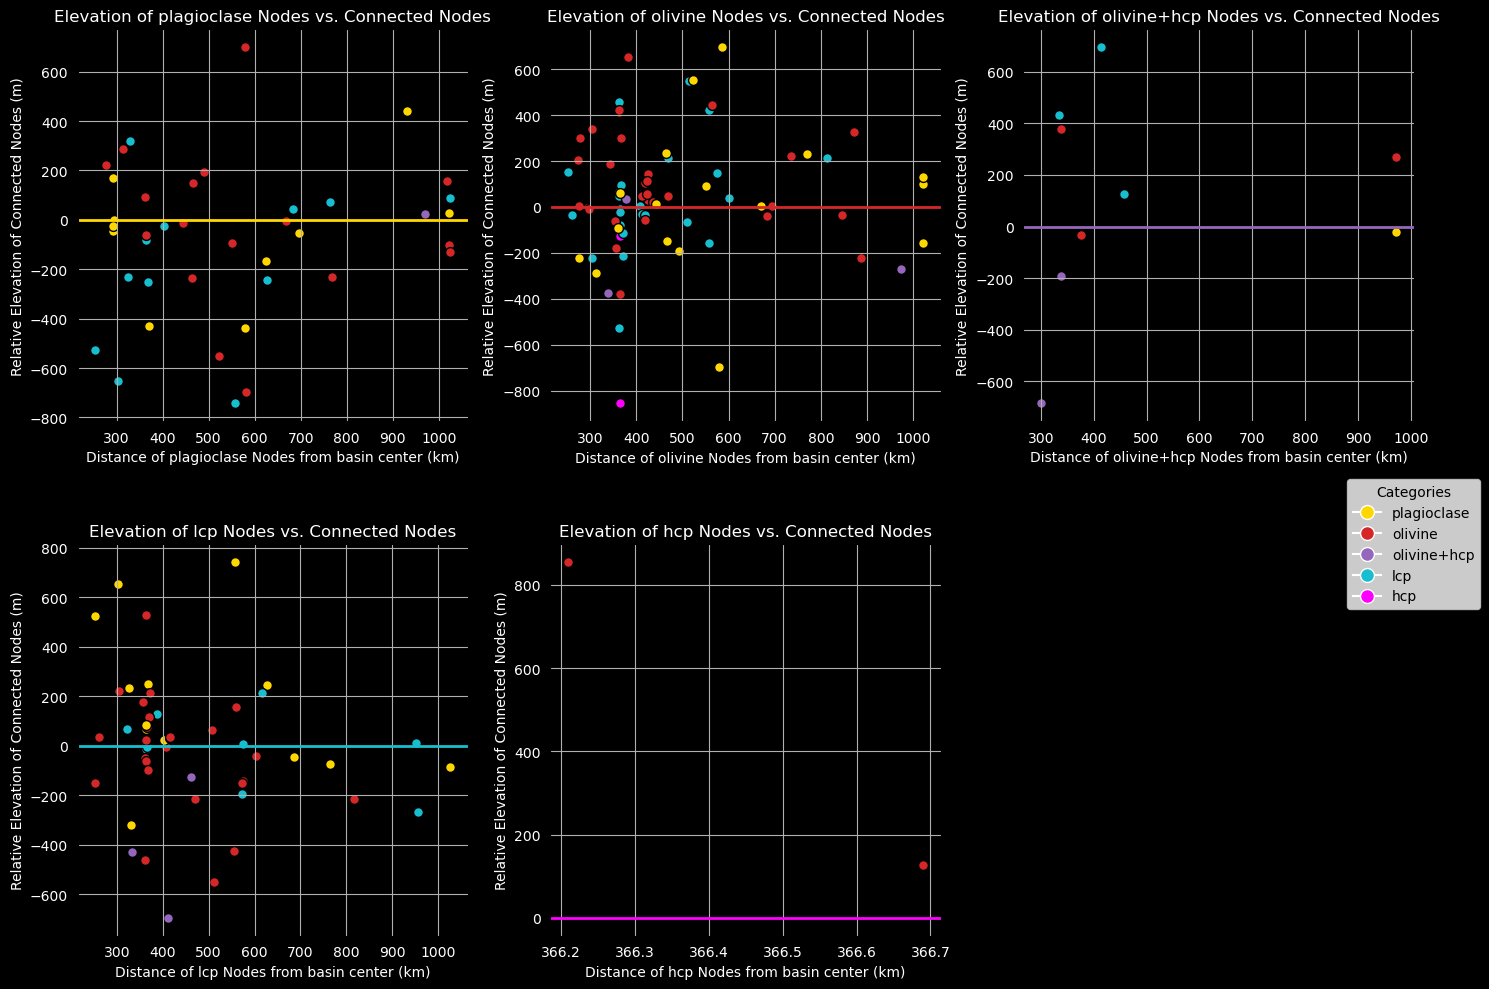

In [30]:
import matplotlib.pyplot as plt

category_colors = {'plagioclase': 'gold',
                   'olivine': 'tab:red',
                   'olivine+hcp': 'tab:purple',
                   'olivine+lcp': 'blue',
                   'olivine+plagioclase': 'orangered',
                   'lcp': 'tab:cyan',
                   'hcp': 'magenta',
                   'lcp+hcp': 'cornflowerblue'}

# category_colors = {
#     'Olivine (Fe/Mg)': 'tab:green',
#     'HCP': 'magenta',
#     'LCP': 'tab:cyan',
#     'Plagioclase': 'gold'
# }
skip_cats = ['olivine+lcp', 'olivine+plagioclase', 'lcp+hcp']

# filter out the categories we don't want from category_colors
category_colors = {key: value for key, value in category_colors.items() if key not in skip_cats}

connected_elevations_dict = {}

# fig, ax = plt.figure(figsize=(10, 6))
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
axs = [ax1, ax2, ax3, ax4, ax5, ax6]
for ref_cat, ax in zip(category_colors.keys(), axs):
    plt.sca(ax)
    # Create lists to store data for the plot
    plagioclase_distances = []
    plagioclase_elevations = []
    connected_elevations = []
    connected_categories = []
    # Iterate through all edges in the graph
    for node1, node2 in G.edges():
        # Get the category of node1 (the source node)
        category_node1 = gdf_filtered.loc[node1, 'Category']
        category_node2 = gdf_filtered.loc[node2, 'Category']
        # fid_node1 = gdf_filtered.loc[node1, 'FID']
        # fid_node2 = gdf_filtered.loc[node2, 'FID']
        
        if category_node1 == ref_cat:
            # Get the elevation of node1
            distance_node1 = gdf_filtered.loc[node1, 'Distance_to_center_km']
            elevation_node1 = G.nodes[node1]['position'][2]
            
            # Get the elevation of node2 (connected node)
            elevation_node2 = G.nodes[node2]['position'][2]
            
            # Append the data for plotting
            plagioclase_distances.append(distance_node1)
            plagioclase_elevations.append(elevation_node1)
            connected_elevations.append(elevation_node2 - elevation_node1)
            connected_categories.append(category_node2)
        elif category_node2 == ref_cat:
            # Get the elevation of node2
            distance_node2 = gdf_filtered.loc[node2, 'Distance_to_center_km']
            elevation_node2 = G.nodes[node2]['position'][2]
            
            # Get the elevation node1 (connected node)
            elevation_node1 = G.nodes[node1]['position'][2]
            
            # Append the data for plotting
            plagioclase_distances.append(distance_node2)
            plagioclase_elevations.append(elevation_node2)
            connected_elevations.append(elevation_node1 - elevation_node2)
            connected_categories.append(category_node1)
    connected_elevations_dict[ref_cat] = connected_elevations
    # Now plot the data with category-specific colors
    plt.axhline(y=0, color=category_colors[ref_cat], linewidth=2)  # Add a horizontal line at y=0
    # Loop through the connected categories and assign the appropriate color
    for i, category in enumerate(connected_categories):
        # if category in skip_cats:
        #     print('beep boop')
        #     continue
        # if category == 'Plagioclase':
        #     continue
        color = category_colors.get(category, 'gray')  # Default to gray if category is not in the dictionary
        plt.scatter(plagioclase_distances[i], connected_elevations[i],
                    color=color, edgecolors='black', s=50)

    plt.gca().set_facecolor('black')  # Axes background color
    plt.gcf().set_facecolor('black')  # Figure background color
    # Set plot labels and title
    plt.title(f'Elevation of {ref_cat} Nodes vs. Connected Nodes', color='white')
    plt.xlabel(f'Distance of {ref_cat} Nodes from basin center (km)', color='white')
    plt.ylabel('Relative Elevation of Connected Nodes (m)', color='white')
    plt.grid(True)
    plt.xticks(color='white')
    plt.yticks(color='white')

    # Add a legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=category) 
            for category, color in category_colors.items()]
plt.sca(ax6)
plt.gca().set_facecolor('black')  # Axes background color
plt.gcf().set_facecolor('black')  # Figure background color
plt.legend(handles=handles, title="Categories", loc='center', bbox_to_anchor=(1, 1))
# plt.legend(handles=handles, title="Categories", loc='center', prop={'size': 12})
# Show the plot
plt.tight_layout()
plt.show()

# plt.figure(figsize=(10, 6))
# plt.axhline(y=0, color='gold', linewidth=2)  # Add a horizontal line at y=0
# # Loop through the connected categories and assign the appropriate color
# for i, category in enumerate(connected_categories):
#     # if category == 'plagioclase':
#     #     continue
#     color = category_colors.get(category, 'gray')  # Default to gray if category is not in the dictionary
#     plt.scatter(plagioclase_elevations[i], connected_elevations[i], 
#                 color=color, edgecolors='black', s=50)

# plt.gca().set_facecolor('black')  # Axes background color
# plt.gcf().set_facecolor('black')  # Figure background color
# # Set plot labels and title
# plt.title('Elevation of Plagioclase Nodes vs. Connected Nodes', color='white')
# plt.xlabel('Elevation of Plagioclase Nodes (m)', color='white')
# plt.ylabel('Relative Elevation of Connected Nodes (m)', color='white')
# plt.grid(True)
# plt.xticks(color='white')
# plt.yticks(color='white')

# # Add a legend
# handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=category) 
#            for category, color in category_colors.items()]
# plt.legend(handles=handles, title="Categories", loc='upper left', bbox_to_anchor=(1, 1))

# # Show the plot
# plt.show()


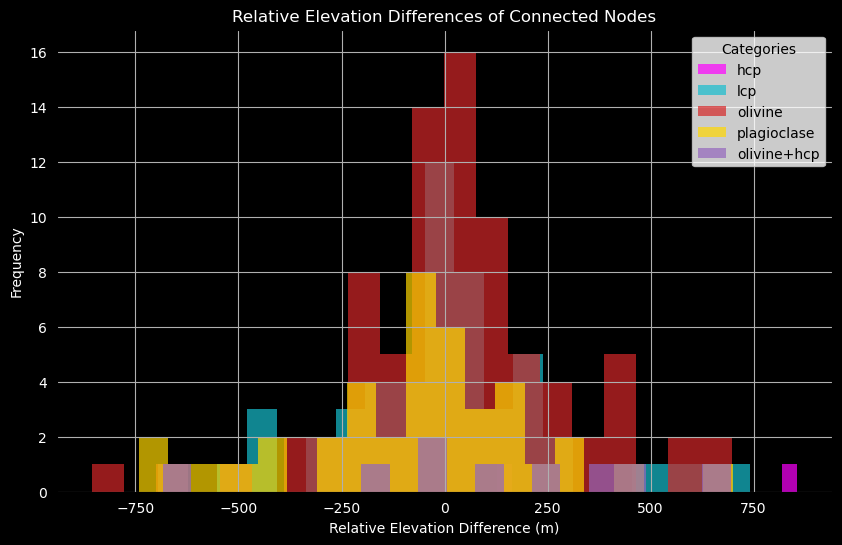

In [ ]:
# make a histogram of the relative elevation differences
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(connected_elevations_dict['hcp'], bins=20, color='magenta', alpha=0.7, label='hcp')
plt.hist(connected_elevations_dict['lcp'], bins=20, color='tab:cyan', alpha=0.7, label='lcp')
plt.hist(connected_elevations_dict['olivine'], bins=20, color='tab:red', alpha=0.7, label='olivine')
plt.hist(connected_elevations_dict['plagioclase'], bins=20, color='gold', alpha=0.7, label='plagioclase')
plt.hist(connected_elevations_dict['olivine+hcp'], bins=20, color='tab:purple', alpha=0.7, label='olivine+hcp')
plt.gca().set_facecolor('black')  # Axes background color
plt.gcf().set_facecolor('black')  # Figure background color
plt.title('Relative Elevation Differences of Connected Nodes', color='white')
plt.xlabel('Relative Elevation Difference (m)', color='white')
plt.ylabel('Frequency', color='white')
plt.grid(True)
plt.xticks(color='white')
plt.yticks(color='white')
plt.legend(title='Categories', loc='upper right')
plt.show()




2.817466213567839 0.026677897673168718


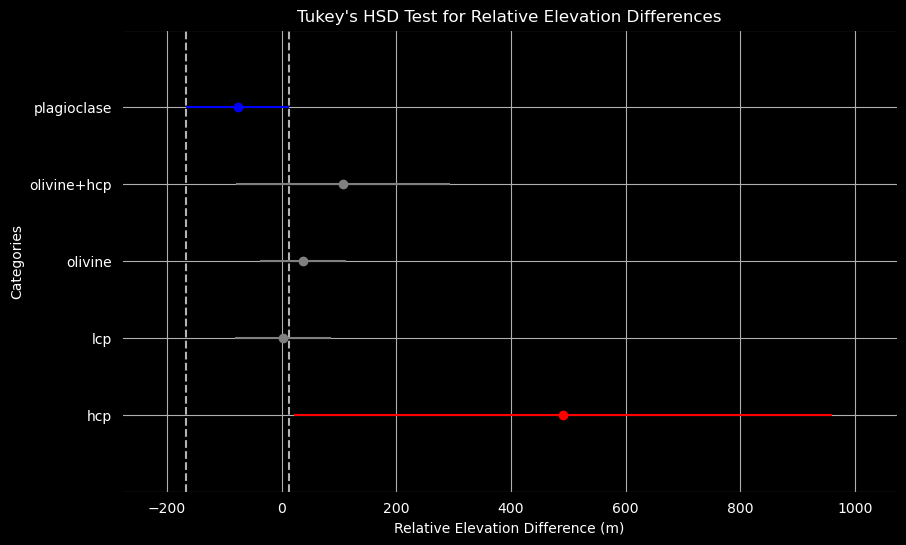

In [90]:
# run an anova to see if the relative elevation differences are significantly different
import scipy.stats as stats

# Perform one-way ANOVA
# first, remove any NaN values
connected_elevations_dict = {key: [val for val in connected_elevations if not np.isnan(val)] for key, connected_elevations in connected_elevations_dict.items()}
f_stat, p_value = stats.f_oneway(connected_elevations_dict['hcp'], connected_elevations_dict['lcp'], connected_elevations_dict['olivine'], connected_elevations_dict['plagioclase'], connected_elevations_dict['olivine+hcp'])

# Display the F-statistic and p-value
print(f_stat, p_value)

# perform a multiple comparison test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Combine all the data into a single array
all_data = np.concatenate([connected_elevations_dict['hcp'], connected_elevations_dict['lcp'], connected_elevations_dict['olivine'], connected_elevations_dict['plagioclase'], connected_elevations_dict['olivine+hcp']])
# Create labels for the groups
group_labels = ['hcp'] * len(connected_elevations_dict['hcp']) + ['lcp'] * len(connected_elevations_dict['lcp']) + ['olivine'] * len(connected_elevations_dict['olivine']) + ['plagioclase'] * len(connected_elevations_dict['plagioclase']) + ['olivine+hcp'] * len(connected_elevations_dict['olivine+hcp'])

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(all_data, group_labels, alpha=0.05)

# Display the results of the Tukey's HSD test
tukey_results.summary()

# Plot the results of the Tukey's HSD test
fig, ax = plt.subplots(figsize=(10, 6))
tukey_results.plot_simultaneous(comparison_name='plagioclase', ax=ax)
plt.gca().set_facecolor('black')  # Axes background color
plt.gcf().set_facecolor('black')  # Figure background color
plt.title("Tukey's HSD Test for Relative Elevation Differences", color='white')
plt.xlabel('Relative Elevation Difference (m)', color='white')
plt.ylabel('Categories', color='white')
plt.grid(True)
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()